https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.2 MB/s eta 0:00:00


In [ ]:
!pip install lingua-language-detector

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install transformers torch sentencepiece

In [ ]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
# IMPORT LIBRARIES

# Standard Library & System
import gc
import html
import os
import re
from collections import Counter

# Data Manipulation & Math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Core & Utilities
import emoji
import nltk
import spacy
import stanza
from deep_translator import GoogleTranslator
from lingua import Language, LanguageDetectorBuilder
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Machine Learning (Scikit-learn)
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC

# Deep Learning & Transformers
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Environment & Progress Bars
from google.colab import drive
from tqdm.notebook import tqdm

In [ ]:
# Mount drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
stanza.download('it')
stanza.download('en')
stanza.download('es')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: it (Italian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/it/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


# DATA

UPLOAD THE DATASETS

In [ ]:
# Directory
DATA_DIR = "/content/drive/MyDrive/TextMining/Project/Datasets"

# Dataset upload
df_it = pd.read_csv(f"{DATA_DIR}/train_it.csv")
df_es = pd.read_csv(f"{DATA_DIR}/train_es.csv")
df_en = pd.read_csv(f"{DATA_DIR}/train_en.csv")

In [ ]:
df_it

,id,text,bio,label,lang
0,it_1231,La destra Italiana pur di non dire che loro od...,Il rispetto per il prossimo qualunque sia il s...,0,it
1,it_1713,"""Presupporre che tutti i bisessuali non sono m...",𝓕𝓲𝓵𝓵𝓮𝓭 𝔀𝓲𝓽𝓱 𝓯𝓾𝓻𝔂 𝓪𝓷𝓭 𝓼𝓽𝓪𝓻𝓻𝔂 𝓮𝔂𝓮𝓭,0,it
2,it_1474,"Se i diritti devono essere uguali, voglio che ...",User Experience Designer URL,0,it
3,it_58,che poi molti uomini trans subiscono lesbofobi...,"no matter where i go, you're there …",0,it
4,it_511,Che poi è l’etero medio come Pio e Amedeo che ...,T'appartengo ed io ci tengo \nE se prometto po...,0,it
...,...,...,...,...,...
1081,it_1340,Io mi sono rotto i coglioni di tutte queste po...,"Se incapaci di scherzare, se il resto del mond...",0,it
1082,it_595,"come una donna cis non può subire transfobia, ...",알잖아 널 가만히 둘 수 없는 걸,0,it
1083,it_844,Ehi comunità @USER questo giornalista di repub...,NaN,0,it
1084,it_1216,"@USER tom felton non è transfobico, ma ha anch...",NaN,0,it


In [ ]:
df_es

,id,text,bio,label,lang
0,es_1850,28 de Junio - Día Internacional del Orgullo LG...,Doblajes Para Videojuegos que nunca tuvieron D...,0,es
1,es_773,"@USER no me gusta la Montero, por su apoyo a l...","Activista, sindicalista, madre y parte de la R...",0,es
2,es_1899,Es la semana del #GayPride y la dedicaré al #Q...,Pintor daltónico que habla de arte. Confundo e...,0,es
3,es_685,@USER @USER @USER A la carles vais los #TRANSF...,mujer Algemesí Valencia Telegram @USER\n+34 62...,0,es
4,es_1717,"Hoy a las 00:10 en TVE2, estreno del documenta...",Comunidad LGTBI+ sin ánimo de lucro. Reivindic...,0,es
...,...,...,...,...,...
871,es_2072,@USER @USER @USER @USER @USER @USER Tampoco me...,"""Cada pobo diferente ten o seu ideal revolucio...",0,es
872,es_1617,Derechos y personas trans.\n URL\n¿Por qué “qu...,Profesor de Psicologia Social. Departament de ...,0,es
873,es_357,"Personas únicas, divertidas, risueñas, creativ...",¡Conoce URL La herramienta gratuita para unifi...,0,es
874,es_396,"Quiero ser, quiero hacer, y quiero no tener mi...",MADE IN CANARY ISLAND🇮🇨\nSOCIAL\nELIGE QUIEN Q...,1,es


In [ ]:
df_en

,id,text,label,lang
0,en_1021,"I've never heard anyone use the word ""faggot"" ...",0,en
1,en_1496,So you don't see the slighest problem of someb...,0,en
2,en_1312,"And to be fair, getting triggered by slurs is ...",1,en
3,en_469,"I kinda feel like it's saying ""the faggot comm...",0,en
4,en_565,"Homophobia, racism, and the resulting endless ...",0,en
...,...,...,...,...
1021,en_450,I'd rather be called faggot then queer for som...,0,en
1022,en_743,"Bro you dont get to gatekeep homophobia, and y...",0,en
1023,en_208,Ur mum gay \n\nUr dad lesbian \n\nUr granny tr...,0,en
1024,en_1331,The only word that bothers me is faggot. Very ...,0,en


MERGE THE DATASETS INTO A SINGLE ONE

In [ ]:
# Full dataset
df_all = pd.concat([df_it, df_es, df_en], axis=0, ignore_index=True)

df_all.shape

(2988, 5)

# EDA

MISSING VALUES

In [ ]:
# Missing values
na_counts = df_all.isna().sum()
na_counts.name = "NA"
na_counts

,NA
id,0
text,0
bio,1161
label,0
lang,0


TEXTS AND BIOS THAT ARE NOT CODED IN A STRING FORMAT

In [ ]:
# Number of observations with a text that's not a string value
print(df_all["text"].apply(lambda x: not isinstance(x, str)).sum())

0


In [ ]:
# Number of observations with a bio that's not a string value
print(df_all["bio"].fillna("").apply(lambda x: not isinstance(x, str)).sum())

0


DUPLICATED TEXTS

In [ ]:
# Duplicate texts
df_all[df_all["text"].duplicated(keep=False)]

,id,text,bio,label,lang
1098,es_643,Hoy y todos los días enfatizamos la importanci...,"Sladom, la 1er. tienda leather y BDSM en Méxic...",0,es
1169,es_1821,🏳️‍🌈 Seguiremos pintando baldosas de amarillo ...,“Hay que ser absolutamente moderno”,0,es
1274,es_708,"""Nos convertimos en lo que pensamos.""\n.\n.\n....",ONG dedicada a apoyar y ayudar a la Comunidad ...,0,es
1337,es_634,“Me da orgullo lo que soy.”\n.\n.\n.\n.\n#tuyy...,(Cualquier pronombre/Any pronoun) Licenciadx e...,0,es
1406,es_642,Hoy y todos los días enfatizamos la importanci...,"Sladom, la 1er. tienda leather y BDSm en Méxic...",0,es
1630,es_707,"""Nos convertimos en lo que pensamos.""\n.\n.\n....",(Cualquier pronombre/Any pronoun) Licenciadx e...,0,es
1794,es_1827,🏳️‍🌈 Seguiremos pintando baldosas de amarillo ...,“Hay que ser absolutamente moderno”,0,es
1808,es_1815,🏳️‍🌈 Seguiremos pintando baldosas de amarillo ...,“Hay que ser absolutamente moderno”,0,es
1858,es_635,“Me da orgullo lo que soy.”\n.\n.\n.\n.\n#tuyy...,ONG dedicada a apoyar y ayudar a la Comunidad ...,0,es


*5 rows to be removed*

In [ ]:
# Removing duplicated texts
df_all = df_all.drop_duplicates(subset="text", keep="first")

df_all.shape

(2983, 5)

CLASS DISTRIBUTION

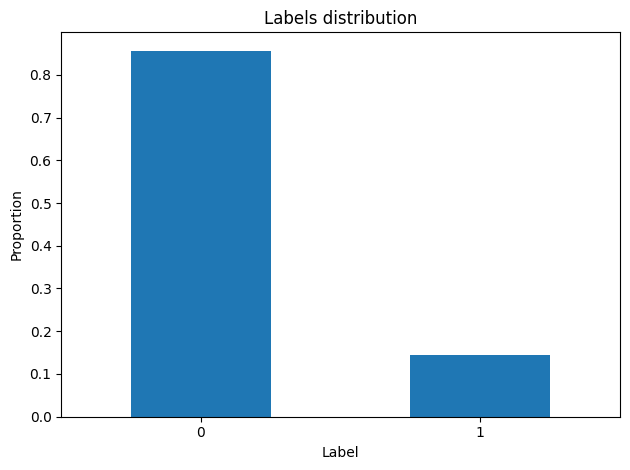

In [ ]:
# Barplot showing the class distribution
dist = df_all["label"].value_counts(normalize=True).plot.bar()

# Plot
dist.set_title("Labels distribution")
dist.set_xlabel("Label")
dist.set_ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

*Strong class imbalance*

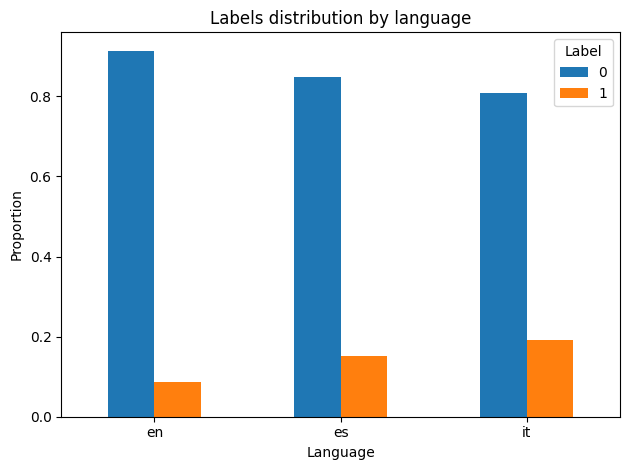

In [ ]:
# Barplot showing the class distribution by language
dist = df_all.groupby("lang")["label"].value_counts(normalize=True).unstack().plot.bar()

# Plot
dist.set_title("Labels distribution by language")
dist.set_xlabel("Language")
dist.set_ylabel("Proportion")
plt.xticks(rotation=0)
dist.legend(title="Label")
plt.tight_layout()
plt.show()

## TEXT CLEANING

In [ ]:
# Function that normalizes all whitespace characters (tabs, newlines) to a single space
def clean_whitespaces(text):
    if not isinstance(text, str):
        return text

    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
# Function that converts emojis into a string format
def demojize_emojis(text):
    if not isinstance(text, str):
        return text

    return emoji.demojize(text, delimiters=(" __", "__ "))

In [ ]:
# "text" variable cleaning
df_all["text_processed"] = (df_all["text"].apply(clean_whitespaces)
                                              .apply(demojize_emojis))

# "bio" variable cleaning
df_all["bio_processed"] = (df_all["bio"].apply(clean_whitespaces)
                                            .apply(demojize_emojis))

## TEXTS AND BIOS ANALYSIS

TEXTS LENGTH

In [ ]:
# Initialization of the tokenizer for informal texts (mantain emojis, hashtags, mentions, abbreviations, contractions, punctuation, urls)
tknzr = TweetTokenizer()

In [ ]:
# Extract the tokens from the texts
df_all["text_tokens"] = df_all["text_processed"].apply(lambda x: tknzr.tokenize(x))

# Count the found tokens in each text
df_all["text_n_tokens"] = df_all["text_tokens"].apply(lambda x: len(x))

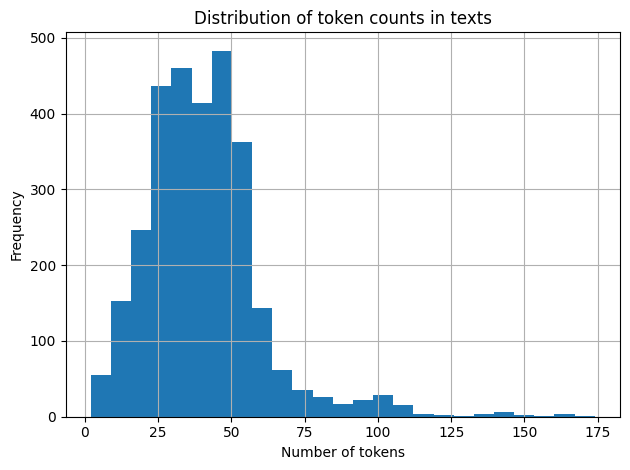

In [ ]:
# Histogram of the number of tokens per text
dist = df_all["text_n_tokens"].hist(bins=25)

# Plot
dist.set_title("Distribution of token counts in texts")
dist.set_xlabel("Number of tokens")
dist.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

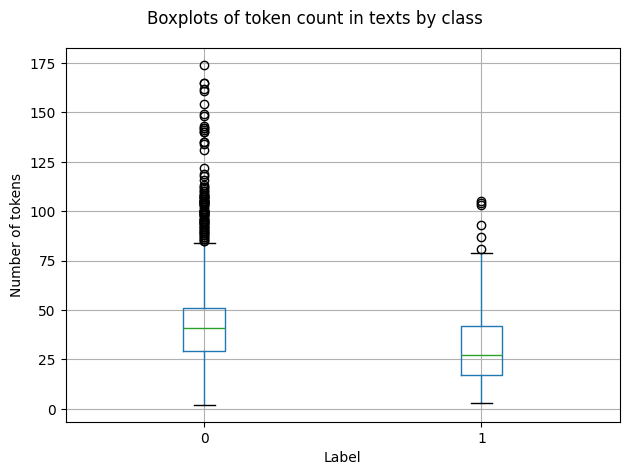

In [ ]:
# Boxplots per class
boxplots = df_all.boxplot(column="text_n_tokens", by="label")

# Plot
plt.suptitle("Boxplots of token count in texts by class")
boxplots.set_title("")
boxplots.set_xlabel("Label")
boxplots.set_ylabel("Number of tokens")
plt.tight_layout()
plt.show()

BIOS LENGTH

In [ ]:
# Extract the tokens from the bios
df_all["bio_tokens"] = df_all["bio_processed"].apply(lambda x: tknzr.tokenize(x) if isinstance(x, str) else None)

# Count the found tokens in each bio
df_all["bio_n_tokens"] = df_all["bio_tokens"].apply(lambda x: len(x) if isinstance(x, list) else None)

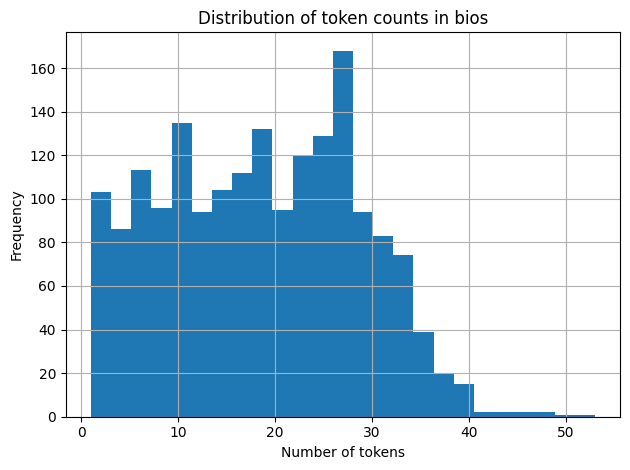

In [ ]:
# Histogram
dist = df_all["bio_n_tokens"].hist(bins=25)

# Plot
dist.set_title("Distribution of token counts in bios")
dist.set_xlabel("Number of tokens")
dist.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

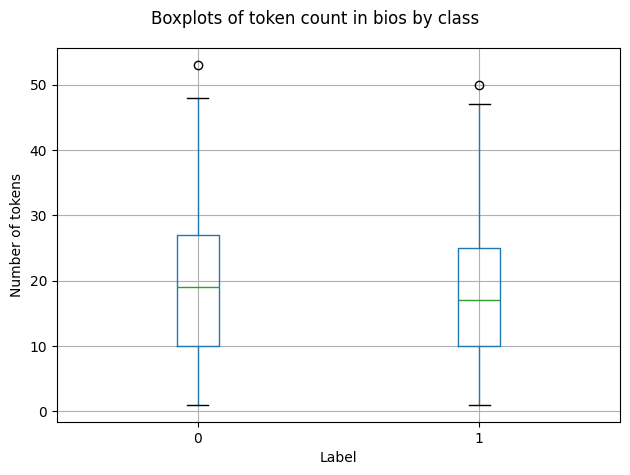

In [ ]:
# Boxplots per class
boxplots = df_all.boxplot(column="bio_n_tokens", by="label")

# Plot
plt.suptitle("Boxplots of token count in bios by class")
boxplots.set_title("")
boxplots.set_xlabel("Label")
boxplots.set_ylabel("Number of tokens")
plt.tight_layout()
plt.show()

BIO PRESENCE RATE BY CLASS

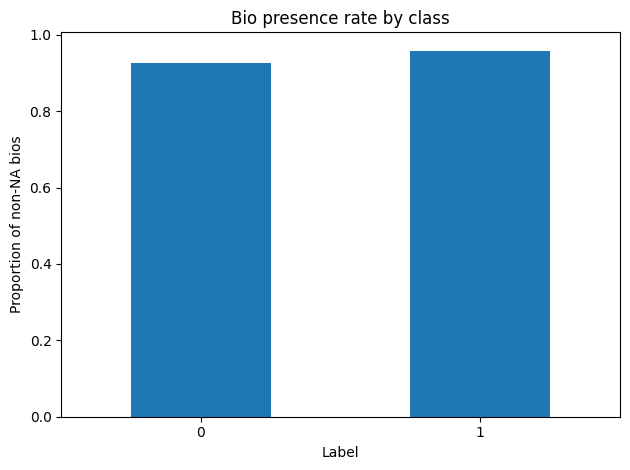

In [ ]:
# Barplot of rows with bio per class
dist = (df_all[df_all['lang']!='en'].assign(has_bio=df_all["bio"].notna())
                              .groupby("label")["has_bio"]
                              .mean())

# Plot
dist.plot.bar()
plt.xlabel("Label")
plt.ylabel("Proportion of non-NA bios")
plt.title("Bio presence rate by class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

TEXTS CAPS LOCK RATIO

In [ ]:
# Texts caps lock ratio
df_all["text_capslock_ratio"] = df_all["text"].apply(
    lambda text: (len([c for c in text if c.isalpha() and c.isupper()]) /
                  len([c for c in text if c.isalpha()])))


In [ ]:
def proportion_caps_lock_words(text_tokens):
    # all the words
    word_tokens = [t for t in text_tokens if re.fullmatch(r"[A-Za-z]+", t)]
    if not word_tokens:
        return 0.0
    # all the caps lock words
    all_caps_words = [t for t in word_tokens if t.isupper()]

    return len(all_caps_words) / len(word_tokens)

In [ ]:
df_all["text_capslock_ratio"] = df_all["text_tokens"].apply(proportion_caps_lock_words)

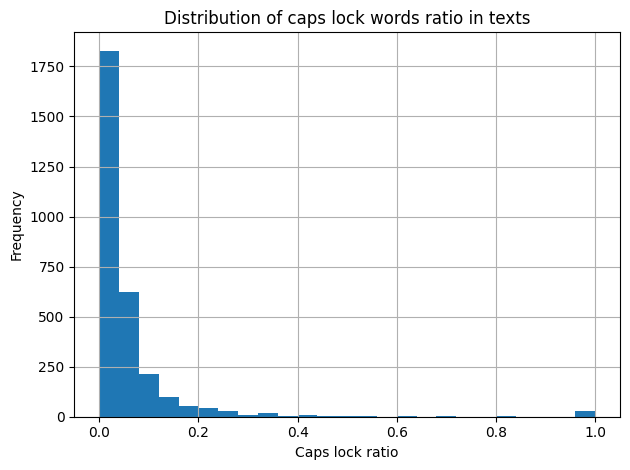

In [ ]:
# Histogram
dist = df_all["text_capslock_ratio"].hist(bins=25)

# Plot
dist.set_title("Distribution of caps lock words ratio in texts")
dist.set_xlabel("Caps lock ratio")
dist.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

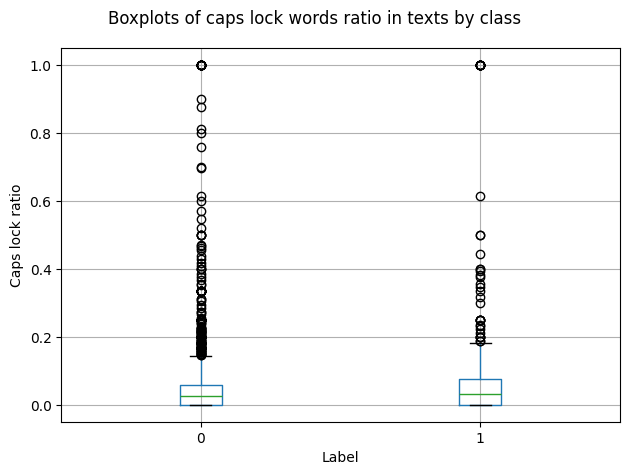

In [ ]:
# Boxplots per class
boxplots = df_all.boxplot(column="text_capslock_ratio", by="label")

# Plot
plt.suptitle("Boxplots of caps lock words ratio in texts by class")
boxplots.set_title("")
boxplots.set_xlabel("Label")
boxplots.set_ylabel("Caps lock ratio")
plt.tight_layout()
plt.show()

AGGRESSIVE PUNCTATION

In [ ]:
# Function that counts how many times a repetition (>2) of ! or ? is present in a text
def count_aggressive_punctuation(text):
    pattern = r"[!?]{3,}"
    matches = re.findall(pattern, text)
    return len(matches)

In [ ]:
# Counts of aggressive punctuation in texts
df_all["text_aggressive_punct"] = df_all["text"].apply(count_aggressive_punctuation)

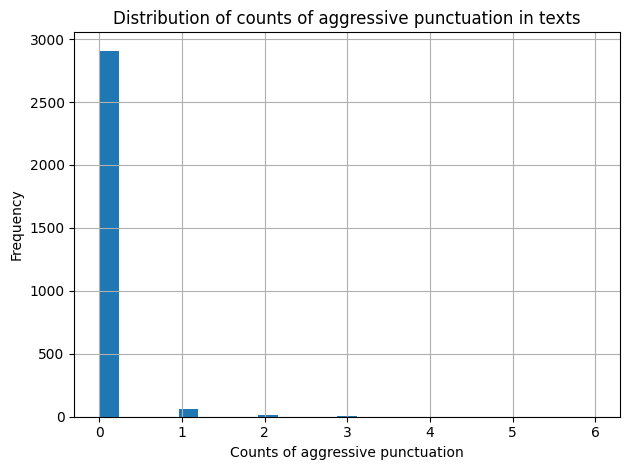

In [ ]:
# Histogram
dist = df_all["text_aggressive_punct"].hist(bins=25)

# Plot
dist.set_title("Distribution of counts of aggressive punctuation in texts")
dist.set_xlabel("Counts of aggressive punctuation")
dist.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## HASHTAGS ANALYSIS

EXTRACT THE HASHTAGS FROM THE TEXT TOKENS LIST

In [ ]:
# Hashtag pattern using regex
hashtag_regex = re.compile(r"^#\w+$")

# Present hashtags in the text
df_all['text_hashtags'] = df_all['text_tokens'].apply(lambda tokens: list(set([t for t in tokens if hashtag_regex.match(t)])) or None)

# Proportion of rows with text containing at least an hashtag per class
df_all["text_has_hashtag"] = df_all["text_hashtags"].apply(lambda x: 1 if isinstance(x, list) else 0)

HASHTAG PRESENCE RATE BY CLASS IN "text" VARIABLE

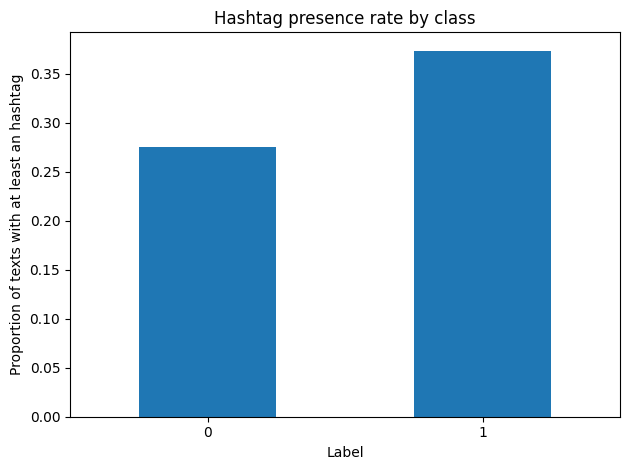

In [ ]:
# Barplot
dist = df_all.groupby("label")["text_has_hashtag"].mean()

# Plot
dist.plot.bar()
plt.xlabel("Label")
plt.ylabel("Proportion of texts with at least an hashtag")
plt.title("Hashtag presence rate by class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

MOST RECURRENT HASHTAGS PER LANGUAGE BY CLASS

In [ ]:
# Function to inspect the presence of each hashtags based on the class
def hashtags_analysis(df_input, lang):
    df = df_input.copy()

    # Filter fd by language
    df = df[df["lang"] == lang]

    # Number of distinct hashtags in the text
    df["n_hashtags"] = df["text_hashtags"].apply(
        lambda x: len(x) if isinstance(x, (list, str)) else 0
        )

    # Total number of rows per class
    total_rows_0 = df[df["label"] == 0].shape[0]
    total_rows_1 = df[df["label"] == 1].shape[0]

    # Initialize counters for hashtag frequency distribution
    hashtags_class_0 = Counter()
    hashtags_class_1 = Counter()

    # Inspect only rows with text containing at least an hashtag
    for _, row in df[df["n_hashtags"] > 0].iterrows():
        for tag in row["text_hashtags"]:
            if row["label"] == 0:
                hashtags_class_0[tag] += 1
            else:
                hashtags_class_1[tag] += 1

    # Create aggregated dataframe (absent hashtags: from NaN to 0)
    tag_df = pd.DataFrame({
        "count_0": pd.Series(hashtags_class_0),
        "count_1": pd.Series(hashtags_class_1)
    }).fillna(0)

    # Proportions per class of rows with a specific hashtag
    tag_df["prop_0"] = tag_df["count_0"] / (total_rows_0 + 1e-4)
    tag_df["prop_1"] = tag_df["count_1"] / (total_rows_1 + 1e-4)

    # Calculate Log-Odds Ratio for each hashtag
    #   Formula: log( count_1 / total_1 ) - log( count_0 / total_0 )
    tag_df["log_odds"] = np.log(tag_df["prop_1"] + 1e-4) - np.log(tag_df["prop_0"] + 1e-4)

    # Only hashtags that appear 10 times in at least one of the two target categories
    tag_df = tag_df[(tag_df["prop_0"] >= 0.05) | (tag_df["prop_1"] >= 0.05)]

    # Sort dataframe based on the log-odds
    return tag_df.sort_values(by="log_odds", ascending=False)

In [ ]:
# Italian results
hashtags_analysis(df_all, lang="it")

,count_0,count_1,prop_0,prop_1,log_odds


In [ ]:
# Spanish results
hashtags_analysis(df_all, lang="es")

,count_0,count_1,prop_0,prop_1,log_odds
#Orgullo2020,17.0,16.0,0.023035,0.120301,1.649469
#OrgulloGay,12.0,7.0,0.016260,0.052632,1.170365
#LoveIsLove,12.0,7.0,0.016260,0.052632,1.170365
#Pride,25.0,13.0,0.033875,0.097744,1.057743
#OrgulloLGTBI,154.0,75.0,0.208672,0.563909,0.993828
#Orgullo,57.0,23.0,0.077236,0.172932,0.805321
#Pride2022,21.0,7.0,0.028455,0.052632,0.613372
#LGTBIQ,50.0,10.0,0.067751,0.075188,0.104010
#LGTBI,94.0,18.0,0.127371,0.135338,0.060625
#bisexual,38.0,3.0,0.051491,0.022556,-0.822896


In [ ]:
# English results
hashtags_analysis(df_all, lang="en")

,count_0,count_1,prop_0,prop_1,log_odds


## EMOJIS ANALYSIS

RESTORE THE EMOJIS

*"text_processed" and "bio_processed" variables*

In [ ]:
# Function that restores emojis from their demojized version (input: text)
def restore_emojis_text(text):
    if not isinstance(text, str):
        return text

    # Callback function called for every match found by re.sub
    def replace_match(match):
        t = match.group(0)

        # Needed to replace the emoji
        shortcode = t.replace("__", ":")

        # Emoji transformation
        em = emoji.emojize(shortcode, language='alias')

        # If emoji.emojize fails(it doesn't find the code of the emoji), return the original string
        if em != shortcode:
            return em
        else:
            return t

    # Replace every occurrence found using the callback logic
    return re.sub(r"__\S+__", replace_match, text)

In [ ]:
# Restore the emojis
df_all["text_processed"] = df_all["text_processed"].apply(restore_emojis_text)
df_all["bio_processed"] = df_all["bio_processed"].apply(restore_emojis_text)

*"text_tokens" and "bio_tokens" variables*

In [ ]:
# Function that restores the emojis from their demojized version (input: list of tokens)
def restore_emojis_list(tokens):
    if not isinstance(tokens, list):
        return tokens

    restored = []

    for t in tokens:
        # Check if the token is a demojized emoji
        if re.compile(r"^__\S+__$").match(t):
            # Needed to replace the emoji
            shortcode = t.replace("__", ":")

            # Emoji transformation
            em = emoji.emojize(shortcode, language='alias')

            # If emoji.emojize fails (it doesn't find the code of the emoji), return the original string
            if em != shortcode:
                restored.append(em)
            else:
                restored.append(t)
        else:
            restored.append(t)
    return restored

In [ ]:
# Restore the emojis
df_all["text_tokens"] = df_all["text_tokens"].apply(restore_emojis_list)
df_all["bio_tokens"] = df_all["bio_tokens"].apply(restore_emojis_list)

EXTRACT THE EMOJIS FROM THE BIO TOKENS LIST

In [ ]:
# Present emojis in the bio
df_all['bio_emojis'] = df_all['bio_tokens'].apply(lambda tokens: list(set([token for token in tokens if token in emoji.EMOJI_DATA])) or None if isinstance(tokens, list) else None)

# Proportion of rows with bio containing at least an emoji per class
df_all["bio_has_emojis"] = df_all["bio_emojis"].apply(lambda x: 1 if isinstance(x, list) else 0)

EMOJIS PRESENCE RATE BY CLASS IN "bio" VARIABLE  
*Only for observations with bio*

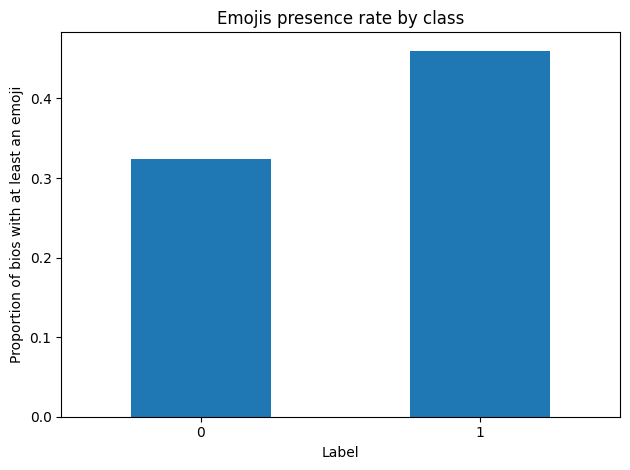

In [ ]:
# Barplot
dist = df_all[df_all["bio"].notna()].groupby("label")["bio_has_emojis"].mean()

# Plot
dist.plot.bar()
plt.xlabel("Label")
plt.ylabel("Proportion of bios with at least an emoji")
plt.title("Emojis presence rate by class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

MOST RECURRENT EMOJIS PER CLASS

In [ ]:
# Function to inspect the presence of each emoji based on the class
def emojis_analysis(df_input):
    df = df_input.copy()

    # Only rows with a bio
    df = df[df["bio"].notna()]

    # Number of distinct emojis in the bio
    df["n_emojis"] = df["bio_emojis"].fillna("").apply(len)

    # Total number of rows per class (NA values excluded)
    total_rows_0 = df[df["label"] == 0]["bio"].notna().sum()
    total_rows_1 = df[df["label"] == 1]["bio"].notna().sum()

    # Initialize counters for emoji frequency distribution
    emojis_class_0 = Counter()
    emojis_class_1 = Counter()

    # Inspect only rows with bio containing at least an emoji
    for _, row in df[df["n_emojis"] > 0].iterrows():
        for em in row["bio_emojis"]:
            if row["label"] == 0:
                emojis_class_0[em] += 1
            else:
                emojis_class_1[em] += 1

    # Create aggregated dataframe (absent emojis: from NaN to 0)
    emoji_df = pd.DataFrame({
        "count_0": pd.Series(emojis_class_0),
        "count_1": pd.Series(emojis_class_1)
    }).fillna(0)

    # Proportions per class of rows with a specific emoji
    emoji_df["prop_0"] = emoji_df["count_0"] / (total_rows_0 + 1e-4)
    emoji_df["prop_1"] = emoji_df["count_1"] / (total_rows_1 + 1e-4)

    # Calculate Log-Odds Ratio for each emoji
    #   Formula: log( count_1 / total_1 ) - log( count_0 / total_0 )
    emoji_df["log_odds"] = np.log(emoji_df["prop_1"] + 1e-4) - np.log(emoji_df["prop_0"] + 1e-4)

    # Only emojis that appear 20 times in at least one of the two target categories
    emoji_df = emoji_df[(emoji_df["count_0"]>=20) | (emoji_df["count_1"] >= 20)]

    # Sort dataframe based on the log-odds
    return emoji_df.sort_values(by="log_odds", ascending=False)

In [ ]:
# Results
emojis_analysis(df_all)

,count_0,count_1,prop_0,prop_1,log_odds
🌈,30.0,18.0,0.020053,0.055215,1.009662
🏳️‍🌈,131.0,61.0,0.087567,0.187117,0.758722
🏳️‍⚧️,28.0,12.0,0.018717,0.036810,0.673739
🇮🇹,51.0,9.0,0.034091,0.027607,-0.210262
♀️,30.0,5.0,0.020053,0.015337,-0.266582
❤️,36.0,5.0,0.024064,0.015337,-0.448077
💜,56.0,6.0,0.037433,0.018405,-0.707189
💛,26.0,2.0,0.017380,0.006135,-1.030866
💙,27.0,2.0,0.018048,0.006135,-1.068394
💚,27.0,2.0,0.018048,0.006135,-1.068394


## PRONOUN PERSON ANALYSIS

In [ ]:
# Function that analyzes a single text and counts the associated person of the words
def get_person_counts(text, nlp_model):
    # We are interested to know whether a text is in first person or not
    c_1st = 0
    c_other = 0

    # Process text with Stanza
    doc = nlp_model(text)

    for sent in doc.sentences:
        for word in sent.words:
            # UPOS (Universal Part of Speech)
            if word.upos in ["PUNCT", "SYM"]:
                continue

            # Check if the word has morphological features
            if not word.feats:
                continue

            # Determine the person of the current word
            is_1st = "Person=1" in word.feats
            is_other = "Person=2" in word.feats or "Person=3" in word.feats

            if not (is_1st or is_other):
                continue

            # Cosnider only subjects and verbs
            is_subject = (word.deprel == "nsubj")
            is_verb = (word.upos in ["VERB", "AUX"])

            if not (is_subject or is_verb):
                continue

            # Syntactic deduplication:
            # Check if word is a subject (nsubj) and its head (verb) has the same person
            head_index = word.head
            # 0 is the root index (represents the main verb of the sentence)
            # Stanza indices for the words starts at 1
            if head_index > 0:
                head_word = sent.words[head_index - 1]

                # Dependency relation
                if word.deprel == "nsubj" and head_word.feats:
                    if is_1st and "Person=1" in head_word.feats:
                        # Skip redundant subject
                        continue
                    if is_other and ("Person=2" in head_word.feats or "Person=3" in head_word.feats):
                        # Skip redundant subject
                        continue

            if is_1st:
                c_1st += 1
            elif is_other:
                c_other += 1

    return c_1st, c_other

In [ ]:
# Function that processes the dataframe by language to count grammatical person tokens
def extract_person_dominance(df):
    # Initialize result column
    df["text_grammar_dominance"] = "neutral"

    target_languages = ['it', 'en', 'es']

    for lang in target_languages:
        print(lang)
        # Filter data for the current language
        subset_idx = df[df["lang"] == lang].index

        # Load Stanza Pipeline
        nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,depparse", use_gpu=True, verbose=False)

        # Extract texts to process
        texts = df.loc[subset_idx, "text"].tolist()

        # Count the number of times a specific person occurs
        results = [get_person_counts(t, nlp) for t in tqdm(texts)]

        # Dominance feature
        dominance = []
        for c_1st, c_other in results:
            if c_1st > c_other:
                dominance.append("1st_person")
            elif c_other > c_1st:
                dominance.append("other_person")
            else:
                dominance.append("neutral")

        # Update the dataframe
        df.loc[subset_idx, "text_grammar_dominance"] = dominance

        # Free up memory before loading the next language model
        del nlp
        gc.collect()

    return df

In [ ]:
# Results
df_all = extract_person_dominance(df_all)

it


100%|██████████| 1086/1086 [02:20<00:00,  7.74it/s]


en


100%|██████████| 1026/1026 [01:49<00:00,  9.40it/s]


es


100%|██████████| 871/871 [02:02<00:00,  7.13it/s]


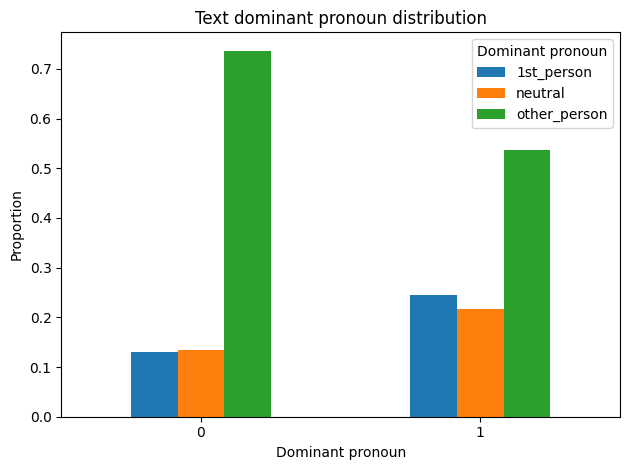

In [ ]:
# Barplot showing the class distribution by class
dist = df_all.groupby("label")["text_grammar_dominance"].value_counts(normalize=True).unstack().plot.bar()

# Plot
dist.set_title("Text dominant pronoun distribution")
dist.set_xlabel("Dominant pronoun")
dist.set_ylabel("Proportion")
plt.xticks(rotation=0)
dist.legend(title="Dominant pronoun")
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING

In [ ]:
# Dataset cleaning from unnecessary columns
df_all = df_all.drop(columns=['text_processed', 'bio_processed', 'text_tokens', 'bio_tokens',
                              'text_aggressive_punct', 'text_has_hashtag', 'bio_has_emojis'])

In [ ]:
# Function to clean the text before extracting features (sentiment, emotion, hatespeech)
def text_cleaning(text):
    # Decode HTML entities (&amp; -> &)
    new_text = html.unescape(text)
    # Handle Mentions @user (Cardiff standard)
    new_text = re.sub(r'@\w+', '@user', new_text)
    # Handle URLs -> http (Cardiff standard)
    new_text = re.sub(r'http\S+|www\.\S+', 'http', new_text)
    # Whitespace normalization
    new_text = re.sub(r'\s+', ' ', new_text).strip()

    return text

## LANGUAGE DETECTION

In [ ]:
# Detector set-up
languages = [Language.ITALIAN, Language.ENGLISH, Language.SPANISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [ ]:
# Function to predict the language of the text
def detect_language(text):
    # Text cleaning
    # URL removal
    clean_text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Mention removal
    clean_text = re.sub(r'@\w+', '', clean_text)
    # Hashtag removal
    clean_text = re.sub(r'#\w+', '', clean_text)

    # Avoid empty texts
    if not clean_text:
        clean_text = text

    # Language detection
    detected_language = detector.detect_language_of(clean_text)

    if detected_language:
        return detected_language.iso_code_639_1.name.lower()

    return None

In [ ]:
# Results
df_all["lang_pred"] = df_all["text"].apply(detect_language)

In [ ]:
# Confusion matrix to display where the model fails
confusion_matrix(df_all['lang'], df_all['lang_pred'], labels=['it', 'en', 'es'])

array([[1084,    2,    0],
       [   0, 1026,    0],
       [   4,    5,  862]])

In [ ]:
# Wrong predictions
df_all[df_all["lang"] != df_all["lang_pred"]][["text", "lang", "lang_pred"]]

,text,lang,lang_pred
489,@USER Poi il 2 dove comunque rivelano che un m...,it,en
908,Sesto e ultimo libro della Pride Month Reading...,it,en
1104,Soy Queer.\n\n#Queer #Orgullo #Pride #Orgullo2...,es,en
1313,It's finally #GayPride! 🏳‍🌈 Enjoy this very sp...,es,en
1371,#Pride#gay #pride #gayboy #lgbt #instagay #gay...,es,it
1374,Califato queer #OrgulloLGTBI URL,es,it
1493,"¡Feliz día, queerfriends! #OrgulloLGTBI",es,en
1732,MARICON ! Y QUEEEEEEEE???🏳️‍🌈#OrgulloLGTBI URL,es,en
1763,Vamos a la ducha. #lgtb #pride #loveislove #lo...,es,en
1888,@USER M a r a v i l l a #MariconPerdidoTNT #Or...,es,it


## TEXT TRANSLATION

In [ ]:
# Function that translates spanish and italian texts to english
def english_translation(df):
    # Translators initialization
    trans_it = GoogleTranslator(source="it", target="en")
    trans_es = GoogleTranslator(source="es", target="en")

    # List to save results into the df
    translations = []

    # Iterate by rows
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Text info
        lang = row["lang_pred"]
        text = row["text"]

        # If the text is in english it remains the same
        if lang == "it":
            text = trans_it.translate(text)
        elif lang == "es":
            text = trans_es.translate(text)

        translations.append(text)

    return translations

In [ ]:
# Results
df_all["text_translated"] = english_translation(df_all)

100%|██████████| 2983/2983 [25:19<00:00,  1.96it/s]


## SENTIMENT ANALYSIS

In [ ]:
# Upload the model
model_sentiment = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Defining the classifier pipeline
classifier_sentiment = pipeline("sentiment-analysis",
                                  model=model_sentiment,
                                  tokenizer=model_sentiment,
                                  return_all_scores=False,
                                  device=0)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Function to perform sentiment analysis on texts
def detect_sentiment(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_sentiment(texts,
                                    batch_size=32,
                                    truncation=True,
                                    max_length=512)

    # List to save results into the df
    sentiment_labels = []
    # Extract the predictions
    for res in results:
        label = res["label"]
        score = res["score"]
        # Force the neutral prediction

        if score < 0.5:
            sentiment_labels.append("neutral")
        else:
            sentiment_labels.append(label)

    return sentiment_labels

In [ ]:
# Extract sentiment
df_all["text_sentiment"] = detect_sentiment(df_all)

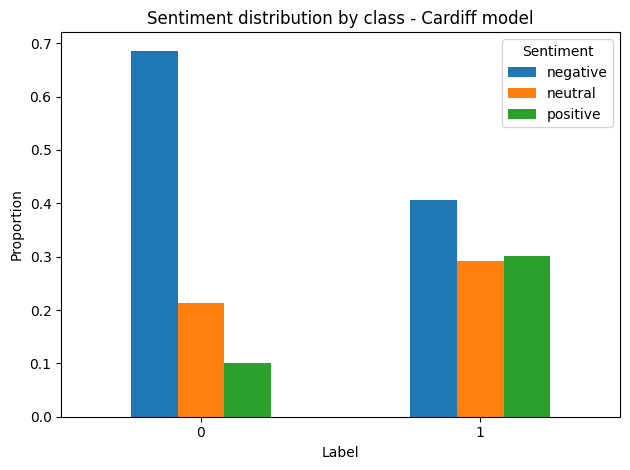

In [ ]:
# Barplot showing the sentiment distribution by class
dist = df_all.groupby("label")["text_sentiment"].value_counts(normalize=True).unstack().plot.bar()

# Plot
dist.set_title("Sentiment distribution by class - Cardiff model")
dist.set_xlabel("Label")
dist.set_ylabel("Proportion")
plt.xticks(rotation=0)
dist.legend(title="Sentiment")
plt.tight_layout()
plt.show()

## EMOTION DETECTION

### J-HARTMANN MODEL

Ekman emotions + neutral

In [ ]:
# Upload the model
model_emotion_jhartmann = "j-hartmann/emotion-english-distilroberta-base"

# Defining the classifier pipeline
classifier_emotion_jhartmann = pipeline("text-classification",
                                          model=model_emotion_jhartmann,
                                          tokenizer=model_emotion_jhartmann,
                                          return_all_scores=False,
                                          device=0)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Function to perform emotion detection
def detect_emotion_jhartmann(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_emotion_jhartmann(texts,
                                            batch_size=32,
                                            truncation=True,
                                            max_length=512)

    # List to save results into the df
    emotion_labels = []
    # Extract the predictions
    emotion_labels = [res["label"] for res in results]

    return emotion_labels

In [ ]:
# Extract emotions
df_all["text_emotion_jhartmann"] = detect_emotion_jhartmann(df_all)

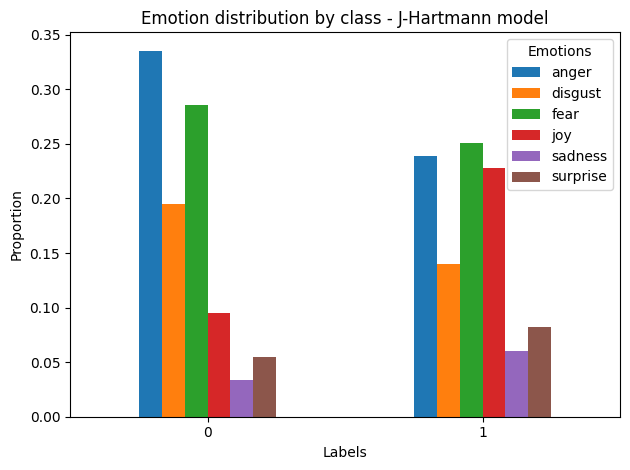

In [ ]:
# Barplot showing the emotions distribution by class
dist = df_all[df_all["text_emotion_jhartmann"]!="neutral"].groupby("label")["text_emotion_jhartmann"].value_counts(normalize=True).unstack().plot.bar()

# Plot
dist.set_title("Emotion distribution by class - J-Hartmann model")
dist.set_xlabel("Labels")
dist.set_ylabel("Proportion")
plt.xticks(rotation=0)
dist.legend(title="Emotions")
plt.tight_layout()
plt.show()

### SAM-LOWE MODEL

27 GoEmotions emotions + neutral

In [ ]:
# Upload the model
model_emotion_samlowe = "SamLowe/roberta-base-go_emotions"

# Defining the classifier pipeline
classifier_emotion_samlowe = pipeline("text-classification",
                                        model=model_emotion_samlowe,
                                        tokenizer=model_emotion_samlowe,
                                        return_all_scores=False,
                                        device=0)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Function to perform emotion detection
def detect_emotion_samlowe(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_emotion_samlowe(texts,
                                          batch_size=32,
                                          truncation=True,
                                          max_length=512)

    # List to save results into the df
    emotion_labels = []
    # Extract the predictions
    emotion_labels = [res["label"] for res in results]

    return emotion_labels

In [ ]:
# Extract emotions
df_all["text_emotion_samlowe"] = detect_emotion_samlowe(df_all)

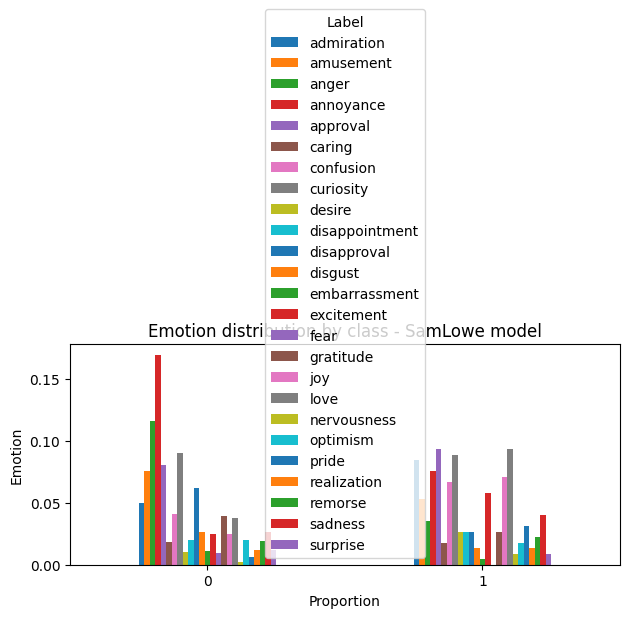

In [ ]:
# Barplot showing the emotions distribution by class
dist = df_all[df_all["text_emotion_samlowe"]!="neutral"].groupby("label")["text_emotion_samlowe"].value_counts(normalize=True).unstack().plot.bar()

# Plot
dist.set_title("Emotion distribution by class - SamLowe model")
dist.set_xlabel("Proportion")
dist.set_ylabel("Emotion")
plt.xticks(rotation=0)
dist.legend(title="Label")
plt.tight_layout()
plt.show()

## 'SIMPLE' FEATURES

In [ ]:
# Min and max values
max_ = df_all["text_n_tokens"].max()
min_ = df_all["text_n_tokens"].min()

# Normalization
df_all["text_n_tokens_norm"] = (df_all["text_n_tokens"] - min_) / (max_ - min_)

In [ ]:
# Min and max values
max_ = df_all["bio_n_tokens"].max()
min_ = df_all["bio_n_tokens"].min()

# Normalization
df_all["bio_n_tokens_norm"] = ((df_all["bio_n_tokens"] - min_) / (max_ - min_)).fillna(0)

In [ ]:

df_all["has_rainbow"] = df_all["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🌈" in x else 0
)

In [ ]:

df_all["has_rainbow_flag"] = df_all["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🏳️‍🌈" in x else 0
)

In [ ]:
df_all["has_trans_flag"] = df_all["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🏳️‍⚧️" in x else 0
)

In [ ]:
df_all = pd.concat(
    [df_all,
     pd.get_dummies(df_all["text_grammar_dominance"],
                    prefix="text_grammar_dominance",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_all = pd.concat(
    [df_all,
     pd.get_dummies(df_all["text_sentiment"],
                    prefix="text_sentiment",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_all = pd.concat(
    [df_all,
     pd.get_dummies(df_all["text_emotion_jhartmann"],
                    prefix="text_emotion_jhartmann",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_all = pd.concat(
    [df_all,
     pd.get_dummies(df_all["text_emotion_samlowe"],
                    prefix="text_emotion_samlowe",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
# Save the df in Colab
df_all.to_pickle("/content/drive/MyDrive/TextMining/Project/Datasets/train_full_processed.pkl")

# MODELS

## LOGISTIC REGRESSION WITH TF-IDF

In [ ]:
df_all = pd.read_pickle("/content/drive/MyDrive/TextMining/Project/Datasets/train_full_processed.pkl")


In [ ]:
# Download NLTK resources
nltk.download('stopwords')

os.system("python -m spacy download it_core_news_sm")
os.system("python -m spacy download es_core_news_sm")

# Upload Spacy
nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp_it = spacy.load("it_core_news_sm", disable=['parser', 'ner'])
nlp_es = spacy.load("es_core_news_sm", disable=['parser', 'ner'])

# Map to choose the model
nlp_map = {"en": nlp_en, "it": nlp_it, "es": nlp_es}

# Tokenizer initialization
tknzr = TweetTokenizer()

# Stopwords set
stop_en = set(stopwords.words('english'))
stop_it = set(stopwords.words('italian'))
stop_es = set(stopwords.words('spanish'))
stop_words_set = stop_en | stop_it | stop_es

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to clean the texts
def remove_noise(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # URL removal
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # Menzioni removal
    text = re.sub(r"@\w+", "", text)
    # Hashtag removal (only the simbol "#")
    text = re.sub(r"#", "", text)
    # Mantain only letters
    text = re.sub(r"[^a-z\s]", "", text)
    # Multiple spaces removal
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
# Function that split the text into tokens
def tokenize(text):
    # TweetTokenizer
    return tknzr.tokenize(text)

In [ ]:
# Function that removes stopwords
def remove_stopwords(tokens):
    # Filter common words and too short ones (1 letter)
    return [t for t in tokens if t not in stop_words_set and len(t) > 1]

In [ ]:
# Function that reduces words to their lemma
def lemmatize(tokens, lang):
    nlp_model = nlp_map[lang]
    # Spacy works on strings or docs
    doc = nlp_model(" ".join(tokens))
    # Lemma extraction
    lemmas = [token.lemma_ for token in doc]

    return lemmas

In [ ]:
# Function for the whole preprocessing phase
def preprocessing_pipeline_tfidf(text, lang):
    text_clean = remove_noise(text)
    tokens = tokenize(text_clean)
    tokens_no_stop = remove_stopwords(tokens)
    lemmas = lemmatize(tokens_no_stop, lang)

    # TF-IDF want a single string with all the words separated by a space
    return " ".join(lemmas)

In [ ]:
# Texts representation extraction
df_all["text_tfidf"] = df_all.apply(
    lambda row: (f"{preprocessing_pipeline_tfidf(row["text"], row["lang_pred"])} {preprocessing_pipeline_tfidf(row["bio"], row["lang_pred"])}"),
    axis=1
)

In [ ]:
# Dictionary to set the params for the tf-idf configuration
tfidf_params = {
    "ngram_range": (1, 1),      # or (1,2) or (1,3)
    "min_df": 5,                # ignore rarest words
    "max_df": 0.9,              # ignore most frequent words
    "max_features": 5000        # None (considers all the words), 10000 is another potential good choice
}

In [ ]:
# Vectorizer initialization
tfidf_vectorizer = TfidfVectorizer(ngram_range=tfidf_params["ngram_range"],
                                    min_df=tfidf_params["min_df"],
                                    max_df=tfidf_params["max_df"],
                                    max_features=tfidf_params["max_features"],
                                    sublinear_tf=True
                                    )

In [ ]:
# Corpus (set of all texts)
corpus = df_all["text_tfidf"].tolist()

# Fit (learns vocabulary) + Transform (creates matrix)
X = tfidf_vectorizer.fit_transform(corpus)

# Word names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Computes the average of the weights for each word on the whole dataset
mean_weights = np.array(X.mean(axis=0)).flatten()

# Create a dataframe
df_vocab = pd.DataFrame({'word': feature_names, 'average_tfidf': mean_weights})

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# Response variable
y = df_all['label']

# Inizializzazione del modello (resta uguale)
clf = LogisticRegression(class_weight='balanced', random_state=44, max_iter=1000)

# F1 scores
cv_result = cross_val_score(clf, X, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.6836


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9123
F1-Score (classe 1): 0.5690


## CONTEXTUALIZED EMBEDDINGS

In [ ]:
# Function that extracts mean-pooled embeddings from text using a pre-trained Transformer model
def get_embeddings(df, model_name, variable="text"):
    print(f"--- Extracting Embeddings with: {model_name} ---")

    # Setup device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device in use: {device}")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    # Evaluation/inference mode (the model is not in a training mode)
    model.eval()

    # Prepare Texts
    texts = df[variable].fillna("").tolist()
    all_embeddings = []

    # Sequential Processing (One by One)
    for text in tqdm(texts):
        # Tokenization
        encoded_input = tokenizer(text,
                                  truncation=True,
                                  max_length=256,
                                  return_tensors="pt").to(device)

        # Inference
        with torch.no_grad(): # no gradient computation
            model_output = model(**encoded_input)

        # Mean pooling:----------------------------------
        token_embeddings = model_output.last_hidden_state   # shape (1, L, H)
        # Calculate mean and max over the sequence length dimension (dim=1)
        sentence_embedding_meanpool = torch.mean(token_embeddings, dim=1).squeeze()
        sentence_embedding_maxpool = torch.max(token_embeddings, dim=1).values.squeeze()

        # Concatenation of the two poolings
        sentence_embedding = torch.cat((sentence_embedding_meanpool, sentence_embedding_maxpool), dim=0)

        # Move to CPU (numpy) to save GPU RAM
        all_embeddings.append(sentence_embedding.cpu().numpy())

    # Concatenate everything into a single giant matrix
    final_matrix = np.vstack(all_embeddings)
    print(f"Embeddings extracted! Shape: {final_matrix.shape}")

    return final_matrix

### XLM-RoBERTa

In [ ]:
# Initialiaze the classifier
clf_log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
clf_ridge = RidgeClassifier(class_weight="balanced")
clf_svm = SVC(kernel="linear", class_weight="balanced")

In [ ]:
# XLM-RoBERTa
model_xlm = "xlm-roberta-base"

X_train_texts_embeddings = get_embeddings(df_all, model_xlm)
X_train_bio_embeddings = get_embeddings(df_all, model_xlm, variable="bio")

--- Extracting Embeddings with: xlm-roberta-base ---
Device in use: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0/2983 [00:00<?, ?it/s]

Embeddings extracted! Shape: (2983, 1536)
--- Extracting Embeddings with: xlm-roberta-base ---
Device in use: cuda


  0%|          | 0/2983 [00:00<?, ?it/s]

Embeddings extracted! Shape: (2983, 1536)


#### FEATURE ENGINEERING

In [ ]:
# Selection of the features from the dataframe to add to the embeddings
features_to_add = ["text_n_tokens_norm",
                   "bio_n_tokens_norm",
                   "text_capslock_ratio",
                   "has_rainbow",
                   "has_rainbow_flag",
                   "has_trans_flag",
                   "text_grammar_dominance_neutral",
                   "text_grammar_dominance_other_person",
                   "text_grammar_dominance_neutral",
                   "text_grammar_dominance_other_person",
                   "text_sentiment_neutral",
                   "text_sentiment_positive",
                   "text_emotion_jhartmann_disgust",
                   "text_emotion_jhartmann_fear",
                   "text_emotion_jhartmann_joy",
                   "text_emotion_jhartmann_neutral",
                   "text_emotion_jhartmann_sadness",
                   "text_emotion_jhartmann_surprise",
                   "text_emotion_samlowe_amusement",
                   "text_emotion_samlowe_anger",
                   "text_emotion_samlowe_annoyance",
                   "text_emotion_samlowe_approval",
                   "text_emotion_samlowe_caring",
                   "text_emotion_samlowe_confusion",
                   "text_emotion_samlowe_curiosity",
                   "text_emotion_samlowe_desire",
                   "text_emotion_samlowe_disappointment",
                   "text_emotion_samlowe_disapproval",
                   "text_emotion_samlowe_disgust",
                   "text_emotion_samlowe_embarrassment",
                   "text_emotion_samlowe_excitement",
                   "text_emotion_samlowe_fear",
                   "text_emotion_samlowe_gratitude",
                   "text_emotion_samlowe_joy",
                   "text_emotion_samlowe_love",
                   "text_emotion_samlowe_nervousness",
                   "text_emotion_samlowe_neutral",
                   "text_emotion_samlowe_optimism",
                   "text_emotion_samlowe_pride",
                   "text_emotion_samlowe_realization",
                   "text_emotion_samlowe_remorse",
                   "text_emotion_samlowe_sadness",
                   "text_emotion_samlowe_surprise"
 ]

In [ ]:
# Extract the numpy matrix to store the adding features
X_train_additional_features = df_all[features_to_add].values

# Horizontal stack
X_train_final = np.hstack((X_train_texts_embeddings, X_train_bio_embeddings, X_train_additional_features))

# Target variable
y_train = df_all["label"]

print(f"Shape Texts Embeddings: {X_train_texts_embeddings.shape}")
print(f"Shape Bio Embeddings:   {X_train_bio_embeddings.shape}")
print(f"Shape Extra Feature:    {X_train_additional_features.shape}")
print("-" * 30)
print(f"FINAL SHAPE (X):       {X_train_final.shape}")

Shape Texts Embeddings: (2983, 1536)
Shape Bio Embeddings:   (2983, 1536)
Shape Extra Feature:    (2983, 43)
------------------------------
FINAL SHAPE (X):       (2983, 3115)


In [ ]:
# F1 scores
cv_result = cross_val_score(clf_log_reg, X_train_final, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.6762


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_log_reg, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_log_reg, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9067
F1-Score (classe 1): 0.5257


In [ ]:
# F1 scores
cv_result = cross_val_score(clf_svm, X_train_final, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.6444


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_svm, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_svm, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.8949
F1-Score (classe 1): 0.4236


In [ ]:
# F1 scores
cv_result = cross_val_score(clf_ridge, X_train_final, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.6352


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_ridge, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_ridge, X_train_final, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.8902
F1-Score (classe 1): 0.4418


#### FEATURE SELECTION

In [ ]:
# RFE selector
rfe_selector = RFE(clf_log_reg, n_features_to_select=300, step=50)

# Fit & Transform
X_train_rfe = rfe_selector.fit_transform(X_train_final, y)

In [ ]:
# F1 scores
cv_result = cross_val_score(clf_log_reg, X_train_rfe, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.7636


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_log_reg, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_log_reg, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9250
F1-Score (classe 1): 0.6522


In [ ]:
# RFE selector
rfe_selector = RFE(clf_svm, n_features_to_select=300, step=50)

# Fit & Transform
X_train_rfe = rfe_selector.fit_transform(X_train_final, y)

In [ ]:
# F1 scores
cv_result = cross_val_score(clf_svm, X_train_rfe, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.8271


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9428
F1-Score (classe 1): 0.7384


In [ ]:
# RFE selector
rfe_selector = RFE(clf_ridge, n_features_to_select=300, step=50)

# Fit & Transform
X_train_rfe = rfe_selector.fit_transform(X_train_final, y)

In [ ]:
# F1 scores
cv_result = cross_val_score(clf_ridge, X_train_rfe, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.8004


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_ridge, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_ridge, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9371
F1-Score (classe 1): 0.7052


SVM

In [ ]:
# RFE selector
rfe_selector = RFE(clf_svm, n_features_to_select=800, step=10)

# Fit & Transform
X_train_rfe = rfe_selector.fit_transform(X_train_final, y)

In [ ]:
# F1 scores
cv_result = cross_val_score(clf_svm, X_train_rfe, y, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.8793


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9608
F1-Score (classe 1): 0.8019


In [ ]:
# Save the selector on drive
joblib.dump(rfe_selector,
            "/content/drive/MyDrive/TextMining/Project/Datasets/selector.joblib")

['/content/drive/MyDrive/TextMining/Project/Datasets/selector.joblib']

#### HYPER-PARAMETER OPTIMIZATION

In [ ]:
X_train_rfe = rfe_selector.transform(X_train_final)

In [ ]:
# Classifier
svc = SVC(class_weight='balanced')

# Param grid
param_grid = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

# Grid search to find the best hyperparameter
grid = GridSearchCV(svc, param_grid, cv=10, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_rfe, y)

print(grid.best_params_)

{'C': 1, 'kernel': 'linear'}


In [ ]:
# F1 scores
cv_result = cross_val_score(clf_svm, X_train_rfe, y_train, cv=10, scoring="f1_macro")

print(f"F1-Score (Macro):   {cv_result.mean():.4f}")

F1-Score (Macro):   0.8793


In [ ]:
# CV (in order to have riproducible splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# F1 per class (iteratively treating the current class as the positive one)
f1_class0 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=0))
f1_class1 = cross_val_score(clf_svm, X_train_rfe, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

print(f"F1-Score (classe 0): {f1_class0.mean():.4f}")
print(f"F1-Score (classe 1): {f1_class1.mean():.4f}")

F1-Score (classe 0): 0.9608
F1-Score (classe 1): 0.8019


#### FINAL TRAINING

In [ ]:
# Feature selector
X_train_rfe = rfe_selector.transform(X_train_final)

In [ ]:
# Training
clf_svm.fit(X_train_rfe, y_train)

SVC(class_weight='balanced', kernel='linear')

In [ ]:
# Save the selector on drive
joblib.dump(clf_svm,
            "/content/drive/MyDrive/TextMining/Project/Datasets/classifier_svm.joblib")

['/content/drive/MyDrive/TextMining/Project/Datasets/classifier_svm.joblib']

# TEST SET

In [ ]:
# Directory
DATA_DIR = "/content/drive/MyDrive/TextMining/Project/Datasets"

# Dataset upload
df_test_it = pd.read_csv(f"{DATA_DIR}/it_test.csv")
df_test_es = pd.read_csv(f"{DATA_DIR}/es_test.csv")
df_test_en = pd.read_csv(f"{DATA_DIR}/en_test.csv")

In [ ]:
# Full dataset
df_test = pd.concat([df_test_it, df_test_es, df_test_en], axis=0, ignore_index=True)

df_test.shape

(1995, 4)

## PRE-PROCESSING

In [ ]:
# Function that normalizes all whitespace characters (tabs, newlines) to a single space
def clean_whitespaces(text):
    if not isinstance(text, str):
        return text

    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
# Function that converts emojis into a string format
def demojize_emojis(text):
    if not isinstance(text, str):
        return text

    return emoji.demojize(text, delimiters=(" __", "__ "))

In [ ]:
# "text" variable cleaning
df_test["text_processed"] = (df_test["text"].apply(clean_whitespaces)
                                              .apply(demojize_emojis))

# "bio" variable cleaning
df_test["bio_processed"] = (df_test["bio"].apply(clean_whitespaces)
                                            .apply(demojize_emojis))

In [ ]:
# Initialization of the tokenizer for informal texts (mantain emojis, hashtags, mentions, abbreviations, contractions, punctuation, urls)
tknzr = TweetTokenizer()

In [ ]:
# Extract the tokens from the texts
df_test["text_tokens"] = df_test["text_processed"].apply(lambda x: tknzr.tokenize(x))

# Count the found tokens in each text
df_test["text_n_tokens"] = df_test["text_tokens"].apply(lambda x: len(x))

In [ ]:
# Extract the tokens from the bios
df_test["bio_tokens"] = df_test["bio_processed"].apply(lambda x: tknzr.tokenize(x) if isinstance(x, str) else None)

# Count the found tokens in each bio
df_test["bio_n_tokens"] = df_test["bio_tokens"].apply(lambda x: len(x) if isinstance(x, list) else None)

In [ ]:
# Texts caps lock ratio
df_test["text_capslock_ratio"] = df_test["text"].apply(
    lambda text: (len([c for c in text if c.isalpha() and c.isupper()]) /
                  len([c for c in text if c.isalpha()])))

In [ ]:
# Function that restores the emojis from their demojized version (input: list of tokens)
def restore_emojis_list(tokens):
    if not isinstance(tokens, list):
        return tokens

    restored = []

    for t in tokens:
        # Check if the token is a demojized emoji
        if re.compile(r"^__\S+__$").match(t):
            # Needed to replace the emoji
            shortcode = t.replace("__", ":")

            # Emoji transformation
            em = emoji.emojize(shortcode, language='alias')

            # If emoji.emojize fails (it doesn't find the code of the emoji), return the original string
            if em != shortcode:
                restored.append(em)
            else:
                restored.append(t)
        else:
            restored.append(t)
    return restored

In [ ]:
# Restore the emojis
df_test["text_tokens"] = df_test["text_tokens"].apply(restore_emojis_list)
df_test["bio_tokens"] = df_test["bio_tokens"].apply(restore_emojis_list)

In [ ]:
# Present emojis in the bio
df_test['bio_emojis'] = df_test['bio_tokens'].apply(lambda tokens: list(set([token for token in tokens if token in emoji.EMOJI_DATA])) or None if isinstance(tokens, list) else None)

# Proportion of rows with bio containing at least an emoji per class
df_test["bio_has_emojis"] = df_test["bio_emojis"].apply(lambda x: 1 if isinstance(x, list) else 0)

In [ ]:
# Function that analyzes a single text and counts the associated person of the words
def get_person_counts(text, nlp_model):
    # We are interested to know whether a text is in first person or not
    c_1st = 0
    c_other = 0

    # Process text with Stanza
    doc = nlp_model(text)

    for sent in doc.sentences:
        for word in sent.words:
            # UPOS (Universal Part of Speech)
            if word.upos in ["PUNCT", "SYM"]:
                continue

            # Check if the word has morphological features
            if not word.feats:
                continue

            # Determine the person of the current word
            is_1st = "Person=1" in word.feats
            is_other = "Person=2" in word.feats or "Person=3" in word.feats

            if not (is_1st or is_other):
                continue

            # Cosnider only subjects and verbs
            is_subject = (word.deprel == "nsubj")
            is_verb = (word.upos in ["VERB", "AUX"])

            if not (is_subject or is_verb):
                continue

            # Syntactic deduplication:
            # Check if word is a subject (nsubj) and its head (verb) has the same person
            head_index = word.head
            # 0 is the root index (represents the main verb of the sentence)
            # Stanza indices for the words starts at 1
            if head_index > 0:
                head_word = sent.words[head_index - 1]

                # Dependency relation
                if word.deprel == "nsubj" and head_word.feats:
                    if is_1st and "Person=1" in head_word.feats:
                        # Skip redundant subject
                        continue
                    if is_other and ("Person=2" in head_word.feats or "Person=3" in head_word.feats):
                        # Skip redundant subject
                        continue

            if is_1st:
                c_1st += 1
            elif is_other:
                c_other += 1

    return c_1st, c_other

In [ ]:
# Function that processes the dataframe by language to count grammatical person tokens
def extract_person_dominance(df):
    # Initialize result column
    df["text_grammar_dominance"] = "neutral"

    target_languages = ['it', 'en', 'es']

    for lang in target_languages:
        print(lang)
        # Filter data for the current language
        subset_idx = df[df["lang"] == lang].index

        # Load Stanza Pipeline
        nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,depparse", use_gpu=True, verbose=False)

        # Extract texts to process
        texts = df.loc[subset_idx, "text"].tolist()

        # Count the number of times a specific person occurs
        results = [get_person_counts(t, nlp) for t in tqdm(texts)]

        # Dominance feature
        dominance = []
        for c_1st, c_other in results:
            if c_1st > c_other:
                dominance.append("1st_person")
            elif c_other > c_1st:
                dominance.append("other_person")
            else:
                dominance.append("neutral")

        # Update the dataframe
        df.loc[subset_idx, "text_grammar_dominance"] = dominance

        # Free up memory before loading the next language model
        del nlp
        gc.collect()

    return df

In [ ]:
# Results
df_test = extract_person_dominance(df_test)

In [ ]:
# Dataset cleaning from unnecessary columns
df_test = df_test.drop(columns=['text_processed', 'bio_processed', 'text_tokens',
                                'bio_tokens', 'bio_has_emojis'])

In [ ]:
# Function that translates spanish and italian texts to english
def english_translation(df):
    # Translators initialization
    trans_it = GoogleTranslator(source="it", target="en")
    trans_es = GoogleTranslator(source="es", target="en")

    # List to save results into the df
    translations = []

    # Iterate by rows
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Text info
        lang = row["lang"]
        text = row["text"]

        # If the text is in english it remains the same
        if lang == "it":
            text = trans_it.translate(text)
        elif lang == "es":
            text = trans_es.translate(text)

        translations.append(text)

    return translations

In [ ]:
# Results
df_test["text_translated"] = english_translation(df_test)

In [ ]:
# Function to clean the text before extracting features (sentiment, emotion, hatespeech)
def text_cleaning(text):
    # Decode HTML entities (&amp; -> &)
    new_text = html.unescape(text)
    # Handle Mentions @user (Cardiff standard)
    new_text = re.sub(r'@\w+', '@user', new_text)
    # Handle URLs -> http (Cardiff standard)
    new_text = re.sub(r'http\S+|www\.\S+', 'http', new_text)
    # Whitespace normalization
    new_text = re.sub(r'\s+', ' ', new_text).strip()

    return text

In [ ]:
# Upload the model
model_sentiment = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Defining the classifier pipeline
classifier_sentiment = pipeline("sentiment-analysis",
                                  model=model_sentiment,
                                  tokenizer=model_sentiment,
                                  return_all_scores=False,
                                  device=0)

In [ ]:
# Function to perform sentiment analysis on texts
def detect_sentiment(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_sentiment(texts,
                                    batch_size=32,
                                    truncation=True,
                                    max_length=512)

    # List to save results into the df
    sentiment_labels = []
    # Extract the predictions
    for res in results:
        label = res["label"]
        score = res["score"]
        # Force the neutral prediction

        if score < 0.5:
            sentiment_labels.append("neutral")
        else:
            sentiment_labels.append(label)

    return sentiment_labels

In [ ]:
# Extract sentiment
df_test["text_sentiment"] = detect_sentiment(df_test)

In [ ]:
# Upload the model
model_emotion_jhartmann = "j-hartmann/emotion-english-distilroberta-base"

# Defining the classifier pipeline
classifier_emotion_jhartmann = pipeline("text-classification",
                                          model=model_emotion_jhartmann,
                                          tokenizer=model_emotion_jhartmann,
                                          return_all_scores=False,
                                          device=0)

In [ ]:
# Function to perform emotion detection
def detect_emotion_jhartmann(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_emotion_jhartmann(texts,
                                            batch_size=32,
                                            truncation=True,
                                            max_length=512)

    # List to save results into the df
    emotion_labels = []
    # Extract the predictions
    emotion_labels = [res["label"] for res in results]

    return emotion_labels

In [ ]:
# Extract emotions
df_test["text_emotion_jhartmann"] = detect_emotion_jhartmann(df_test)

In [ ]:
# Upload the model
model_emotion_samlowe = "SamLowe/roberta-base-go_emotions"

# Defining the classifier pipeline
classifier_emotion_samlowe = pipeline("text-classification",
                                        model=model_emotion_samlowe,
                                        tokenizer=model_emotion_samlowe,
                                        return_all_scores=False,
                                        device=0)

In [ ]:
# Function to perform emotion detection
def detect_emotion_samlowe(df):
    # Texts extraction
    texts = df["text_translated"].tolist()
    # Text cleaning
    texts = [text_cleaning(text) for text in texts]

    # Results
    results = classifier_emotion_samlowe(texts,
                                          batch_size=32,
                                          truncation=True,
                                          max_length=512)

    # List to save results into the df
    emotion_labels = []
    # Extract the predictions
    emotion_labels = [res["label"] for res in results]

    return emotion_labels

In [ ]:
# Extract emotions
df_test["text_emotion_samlowe"] = detect_emotion_samlowe(df_test)

In [ ]:
# Min and max values
max_ = df_test["text_n_tokens"].max()
min_ = df_test["text_n_tokens"].min()

# Normalization
df_test["text_n_tokens_norm"] = (df_test["text_n_tokens"] - min_) / (max_ - min_)

In [ ]:
# Min and max values
max_ = df_test["bio_n_tokens"].max()
min_ = df_test["bio_n_tokens"].min()

# Normalization
df_test["bio_n_tokens_norm"] = ((df_test["bio_n_tokens"] - min_) / (max_ - min_)).fillna(0)

In [ ]:

df_test["has_rainbow"] = df_test["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🌈" in x else 0
)

In [ ]:

df_test["has_rainbow_flag"] = df_test["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🏳️‍🌈" in x else 0
)

In [ ]:
df_test["has_trans_flag"] = df_test["bio_emojis"].apply(
    lambda x: 1 if isinstance(x, list) and "🏳️‍⚧️" in x else 0
)

In [ ]:
df_test = pd.concat(
    [df_test,
     pd.get_dummies(df_test["text_grammar_dominance"],
                    prefix="text_grammar_dominance",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_test = pd.concat(
    [df_test,
     pd.get_dummies(df_test["text_sentiment"],
                    prefix="text_sentiment",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_test = pd.concat(
    [df_test,
     pd.get_dummies(df_test["text_emotion_jhartmann"],
                    prefix="text_emotion_jhartmann",
                    drop_first=True).astype(int)
    ],
    axis=1
)

In [ ]:
df_test = pd.concat(
    [df_test,
     pd.get_dummies(df_test["text_emotion_samlowe"],
                    prefix="text_emotion_samlowe",
                    drop_first=True).astype(int)
    ],
    axis=1
)

## PREDICTIONS

In [ ]:
# Upload the df
df_test = pd.read_pickle("/content/drive/MyDrive/TextMining/Project/Datasets/test_full_processed.pkl")

In [ ]:
# Function that extracts mean-pooled embeddings from text using a pre-trained Transformer model
def get_embeddings(df, model_name, variable="text"):
    print(f"--- Extracting Embeddings with: {model_name} ---")

    # Setup device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device in use: {device}")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    # Evaluation/inference mode (the model is not in a training mode)
    model.eval()

    # Prepare Texts
    texts = df[variable].fillna("").tolist()
    all_embeddings = []

    # Sequential Processing (One by One)
    for text in tqdm(texts):
        # Tokenization
        encoded_input = tokenizer(text,
                                  truncation=True,
                                  max_length=256,
                                  return_tensors="pt").to(device)

        # Inference
        with torch.no_grad(): # no gradient computation
            model_output = model(**encoded_input)

        # Mean pooling:----------------------------------
        token_embeddings = model_output.last_hidden_state   # shape (1, L, H)
        # Calculate mean and max over the sequence length dimension (dim=1)
        sentence_embedding_meanpool = torch.mean(token_embeddings, dim=1).squeeze()
        sentence_embedding_maxpool = torch.max(token_embeddings, dim=1).values.squeeze()

        # Concatenation of the two poolings
        sentence_embedding = torch.cat((sentence_embedding_meanpool, sentence_embedding_maxpool), dim=0)

        # Move to CPU (numpy) to save GPU RAM
        all_embeddings.append(sentence_embedding.cpu().numpy())

    # Concatenate everything into a single giant matrix
    final_matrix = np.vstack(all_embeddings)
    print(f"Embeddings extracted! Shape: {final_matrix.shape}")

    return final_matrix

In [ ]:
# XLM-RoBERTa
# model_xlm = "xlm-roberta-base"

# Embeddings
X_test_texts_embeddings = get_embeddings(df_test, model_xlm)
X_test_bio_embeddings = get_embeddings(df_test, model_xlm, variable="bio")

--- Extracting Embeddings with: xlm-roberta-base ---
Device in use: cuda


  0%|          | 0/1995 [00:00<?, ?it/s]

Embeddings extracted! Shape: (1995, 1536)
--- Extracting Embeddings with: xlm-roberta-base ---
Device in use: cuda


  0%|          | 0/1995 [00:00<?, ?it/s]

Embeddings extracted! Shape: (1995, 1536)


In [ ]:
# Selection of the features from the dataframe to add to the embeddings
features_to_add = ["text_n_tokens_norm",
                   "bio_n_tokens_norm",
                   "text_capslock_ratio",
                   "has_rainbow",
                   "has_rainbow_flag",
                   "has_trans_flag",
                   "text_grammar_dominance_neutral",
                   "text_grammar_dominance_other_person",
                   "text_grammar_dominance_neutral",
                   "text_grammar_dominance_other_person",
                   "text_sentiment_neutral",
                   "text_sentiment_positive",
                   "text_emotion_jhartmann_disgust",
                   "text_emotion_jhartmann_fear",
                   "text_emotion_jhartmann_joy",
                   "text_emotion_jhartmann_neutral",
                   "text_emotion_jhartmann_sadness",
                   "text_emotion_jhartmann_surprise",
                   "text_emotion_samlowe_amusement",
                   "text_emotion_samlowe_anger",
                   "text_emotion_samlowe_annoyance",
                   "text_emotion_samlowe_approval",
                   "text_emotion_samlowe_caring",
                   "text_emotion_samlowe_confusion",
                   "text_emotion_samlowe_curiosity",
                   "text_emotion_samlowe_desire",
                   "text_emotion_samlowe_disappointment",
                   "text_emotion_samlowe_disapproval",
                   "text_emotion_samlowe_disgust",
                   "text_emotion_samlowe_embarrassment",
                   "text_emotion_samlowe_excitement",
                   "text_emotion_samlowe_fear",
                   "text_emotion_samlowe_gratitude",
                   "text_emotion_samlowe_joy",
                   "text_emotion_samlowe_love",
                   "text_emotion_samlowe_nervousness",
                   "text_emotion_samlowe_neutral",
                   "text_emotion_samlowe_optimism",
                   "text_emotion_samlowe_pride",
                   "text_emotion_samlowe_realization",
                   "text_emotion_samlowe_remorse",
                   "text_emotion_samlowe_sadness",
                   "text_emotion_samlowe_surprise"
 ]

In [ ]:
# Features to add
X_test_additional_features = df_test[features_to_add].values

# Horizontal Stack (concatenation)
X_test_final = np.hstack((X_test_texts_embeddings,
                          X_test_bio_embeddings,
                          X_test_additional_features))

print(f"Shape Text Embeddings: {X_test_texts_embeddings.shape}")
print(f"Shape Bio Embeddings:   {X_test_bio_embeddings.shape}")
print(f"Shape Extra Feature:    {X_test_additional_features.shape}")
print("-" * 30)
print(f"FINAL SHAPE (X):       {X_test_final.shape}")

Shape Text Embeddings: (1995, 1536)
Shape Bio Embeddings:   (1995, 1536)
Shape Extra Feature:    (1995, 43)
------------------------------
FINAL SHAPE (X):       (1995, 3115)


In [ ]:
# Upload the selector
rfe_selector = joblib.load('/content/drive/MyDrive/TextMining/Project/Datasets/selector.joblib')

In [ ]:
# RFE transform
X_test_rfe = rfe_selector.transform(X_test_final)

In [ ]:
# Upload the classifier
clf_svm = joblib.load('/content/drive/MyDrive/TextMining/Project/Datasets/classifier_svm.joblib')

In [ ]:
y_test_pred = clf_svm.predict(X_test_rfe)

In [ ]:
df_test_predictions = pd.DataFrame({'id': df_test['id'],
                                    'label': y_test_pred
                                    'lang'; df_test['lang']
                                    })

In [ ]:
df_test_predictions.to_csv('/content/drive/MyDrive/TextMining/Project/df_test_predictions.csv', index=False)